# Вариант 2. Задание 1. A/B–тестирование
**1.1 Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.2 Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

**groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

**groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

**active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

**checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента.

**1.3 Вопросы**

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

*Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.*

**1.4 Требования к ответу**

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [36]:
import pandas as pd
import requests
from urllib.parse import urlencode
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import norm
from tqdm.auto import tqdm

In [ ]:
# ссылки на файлы
groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

# функция для получения загрузочной ссылки c диска (с помощью yandex cloud api)
def get_yandex_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url
groups = pd.read_csv(get_yandex_download_url(groups),sep=';')
groups_add = pd.read_csv(get_yandex_download_url(groups_add),sep=',')
active_studs = pd.read_csv(get_yandex_download_url(active_studs),sep=',')
checks = pd.read_csv(get_yandex_download_url(checks),sep=';')

In [37]:
# на случай, если ссылки не работают:

groups = pd.read_csv('groups.csv', sep=';')
groups_add = pd.read_csv('group_add.csv', sep=',')
active_studs = pd.read_csv('active_studs.csv', sep=',')
checks = pd.read_csv('checks.csv', sep=';')

## EDA:

In [34]:
# датафрейм с пользователями, распределенным на группы: A-контроль, B-целевая
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [35]:
# общая информация о датафрейме:
# -количество строк и столбцов,
# -типы данных
# -присутствуют ли пропуски в значениях
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [20]:
# количество уникальных строк
groups.id.nunique()

# соответствует количеству строк. т.е. все id уникальны

74484

In [16]:
# количество пользователей в сравниваемых (А и B) группах
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [4]:
# дополнительный файл с пользователями, который прислали спустя 2 дня 
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [15]:
# общая информация о датафрейме:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [26]:
# количество уникальных строк
groups_add.id.nunique()

92

In [28]:
# количество пользователей в сравниваемых (А и B) группах
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [5]:
# пользователи, которые зашли на платформу во время проведения эксперимента
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [17]:
# общая информация о датафрейме:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [30]:
# количество уникальных строк
active_studs.nunique()

student_id    8341
dtype: int64

In [38]:
# переименование столбцов для последующего мерджа датафреймов
active_studs = active_studs.rename(columns={'student_id':'id'})

In [8]:
# оплаты, прошедшие на платформе во время проведения эксперимента
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [18]:
# общая информация о датафрейме:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [32]:
# количество уникальных строк
checks.student_id.nunique()

541

In [39]:
# переименование столбцов для последующего мерджа
checks = checks.rename(columns={'student_id':'id'})

In [40]:
# основные описательные статистики:
checks.rev.describe().round(2)

count     541.00
mean     1059.75
std       762.71
min       199.00
25%       290.00
50%       840.00
75%      1900.00
max      4650.00
Name: rev, dtype: float64

In [65]:
# средний чек - 1059.75
# медиана - 840.00
# минимальный - 199.00
# максимальный - 4650.00

**во всех датафремах (groups, groups_add, active_studs, checks) отсутствуют пропуски в данных, значения уникальны, типы данных считаны корректно**

***объединю таблицы:***

In [41]:
groups_final = groups.append(groups_add)
groups_final

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [81]:
# количество пользователей в сравниваемых (А и B) группах
groups_final.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [42]:
# Добавление группы (А или B) пользователям, которые зашли на платформу в дни проведения эксперимента
active_studs = active_studs.merge(groups_final, how='left', on='id')
active_studs

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [30]:
# количество пользователей в сравниваемых (А и B) группах
active_studs.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [43]:
# мердж активных пользователей и оплат, совершенных в дни проведения эксперимента
# удаление строк без оплат
active_users_checks = active_studs.merge(checks, how='left', on='id').dropna()
active_users_checks

,id,grp,rev
62,1184303,A,1530.0000
67,3354191,B,1900.0001
77,3278734,B,1900.0000
99,720651,A,1980.0000
193,1232221,B,1900.0000
...,...,...,...
8201,3890326,B,199.0000
8204,1390994,A,398.0000
8263,1516339,A,290.0000
8277,3910596,B,597.0000


In [33]:
# количество пользователей в сравниваемых (А и B) группах
active_users_checks.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

In [44]:
# мердж всех пользователей и оплат, совершенных в дни проведения эксперимента
# удаление строк без оплат
groups_total_checks = groups_final.merge(checks, how='left', on='id').dropna()
groups_total_checks

,id,grp,rev
1,1627,A,990.0
39,3185,B,690.0
121,25973,B,690.0
125,26280,B,690.0
220,100300,B,990.0
...,...,...,...
74365,5645737,B,1900.0
74381,5651566,B,1900.0
74402,5662322,B,1900.0
74452,5681918,B,1900.0


In [85]:
# количество пользователей в сравниваемых (А и B) группах
groups_total_checks.grp.value_counts()

B    434
A    107
Name: grp, dtype: int64

In [45]:
# добавление оплат активных пользователей ко всем имеющимся оплатам
# удаление дубликатов
not_active_users_checks = groups_total_checks.append(active_users_checks).drop_duplicates(keep=False)
not_active_users_checks

,id,grp,rev
39,3185,B,690.0
121,25973,B,690.0
125,26280,B,690.0
223,100645,B,630.0
254,102534,B,580.0
...,...,...,...
72452,5291900,B,199.0
72753,5331842,B,290.0
73632,5486319,B,199.0
74049,5562806,B,398.0


In [10]:
# платежи пользователей, которые НЕ заходили на платформу в дни проведения эксперимента
not_active_users_checks.grp.value_counts()

B    120
A     29
Name: grp, dtype: int64

**пользователей можно разделить по их активности в дни проведения эсперимента: часть заходили на платформу (==активные), часть - нет**

**в дни проведения эксперимента всего прошло 541 оплат. При этом 392 оплату произвели те пользователи, которые зашли на платформу и были активны в дни проведения эксперимента. Т.е 149 оплат, совершенных в дни эксперимента совершили пользователи, которые не заходили на платформу. Эти пользователи так же имеют свою экспериментальную группу (A или B), при этом бОльшая часть в целевой (B) группе.**

**можно предположить, что оплата была проведена автоматически (в рамках подписки), что не требовало посещения пользователем платформы. проверю суммы оплат среди этих пользователей:**

In [49]:
not_active_users_checks.rev.unique()

array([ 690.    ,  630.    ,  580.    ,  290.    , 1140.    ,  990.    ,
        199.    , 1900.    , 1980.    , 1180.    ,  840.    , 1900.0001,
        398.    ])

**размеры оплат отличаются между собой, что не похоже на автоплатеж по подписке, оплату в рассрочку, etc.**

**таким образом, более вероятным представляется вариант, в котором эти 149 пользователей ошибочно не попали группу "активных". исходя из этого, буду считать активными пользователями всех, кто совершил оплату в дни проведения эксперимента == 541**

**для сравнения экспериментальных групп (учитывая категориальный характер переменных: A/B, оплатил/не оплатил), буду использовать хи-квадрат**

**для этого подготовлю данные:**

In [46]:
# добавлю колонку для данных об оплате
groups_total_checks['pay'] = 'paid'
groups_total_checks.head()

,id,grp,rev,pay
1,1627,A,990.0,paid
39,3185,B,690.0,paid
121,25973,B,690.0,paid
125,26280,B,690.0,paid
220,100300,B,990.0,paid


In [47]:
# мердж всех активных пользователей и все оплаты
df = active_studs.merge(groups_total_checks, how='outer')
df

# в колонке pay имеются пропуски, т.к оплата не произведена

,id,grp,rev,pay
0,581585,A,NaN,NaN
1,5723133,A,NaN,NaN
2,3276743,B,NaN,NaN
3,4238589,A,NaN,NaN
4,4475369,B,NaN,NaN
...,...,...,...,...
8485,5291900,B,199.0,paid
8486,5331842,B,290.0,paid
8487,5486319,B,199.0,paid
8488,5562806,B,398.0,paid


In [48]:
# заменяю пропуски в rev на нули
df.rev = df.rev.fillna(0)
df

,id,grp,rev,pay
0,581585,A,0.0,NaN
1,5723133,A,0.0,NaN
2,3276743,B,0.0,NaN
3,4238589,A,0.0,NaN
4,4475369,B,0.0,NaN
...,...,...,...,...
8485,5291900,B,199.0,paid
8486,5331842,B,290.0,paid
8487,5486319,B,199.0,paid
8488,5562806,B,398.0,paid


In [49]:
# заменяю пропуски в колонке pay на 'not_paid'
df.pay = df.pay.fillna(value='not_paid')
df

,id,grp,rev,pay
0,581585,A,0.0,not_paid
1,5723133,A,0.0,not_paid
2,3276743,B,0.0,not_paid
3,4238589,A,0.0,not_paid
4,4475369,B,0.0,not_paid
...,...,...,...,...
8485,5291900,B,199.0,paid
8486,5331842,B,290.0,paid
8487,5486319,B,199.0,paid
8488,5562806,B,398.0,paid


In [50]:
# таблица сопряженности (для использования критерия хи-квадрат)
df_hi = df \
    .groupby(['grp', 'pay'], as_index=False) \
    .agg({'rev': 'count'}) \
    .rename(columns={'rev': 'revenue'}).reset_index() \
    .pivot(index='grp', columns='pay', values='revenue')
df_hi

pay,not_paid,paid
grp,,
A,1460,107
B,6489,434


In [51]:
# CR в покупку активных пользователей
cr = df_hi.paid / (df_hi.not_paid + df_hi.paid)
cr.round(4)

grp
A    0.0683
B    0.0627
dtype: float64

**при таком сравнении нельзя достоверно сказать, различаются ли СR в группе А и B на самом деле.**

**Использую хи-квадрат:**

**Сформулирую гипотезы:**

- Н0 - отличий между группами нет
- Н1 - есть статистически значимые отличия между группами

In [52]:
statistic, pvalue, dof, expected_freq = chi2_contingency(df_hi)

In [53]:
pvalue

0.4464432666411111

**т.е p- значение > 0.05. у нас нет оснований отклонить нулевую гипотезу**

**различий между группами нет**

**дополнительно рассмотрим различия между пользователями, которые совершили оплату в дни проведения эксперимента:**

In [54]:
payment = groups_total_checks[['id', 'grp', 'rev']]
payment

,id,grp,rev
1,1627,A,990.0
39,3185,B,690.0
121,25973,B,690.0
125,26280,B,690.0
220,100300,B,990.0
...,...,...,...
74365,5645737,B,1900.0
74381,5651566,B,1900.0
74402,5662322,B,1900.0
74452,5681918,B,1900.0


In [55]:
# количество оплат и их сумма
df = payment.groupby('grp', as_index=False).agg({'rev': ('count', 'sum')}).round(2)

# выравниваю столбцы
df.columns = [' '.join(col).strip() for col in df.columns.values]

# переименовываю поля
df = df.rename(columns={'rev count': 'quantity', 'rev sum': 'amount'})

# средний чек (ARPPU)
df['ARPPU'] = round((df.amount / df.quantity), 2)

# медиана
median = payment.groupby('grp', as_index=False).agg({'rev': 'median'}).rename(columns={'rev': 'median_rev'})
df = df.merge(median, on='grp')

df

,grp,quantity,amount,ARPPU,median_rev
0,A,107,92096.0,860.71,690.0
1,B,434,481230.0,1108.82,935.0


**медианное и среднее в целевой группе (В) больше, однако необходимо убедиться в статитсической значимости этих различий**

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


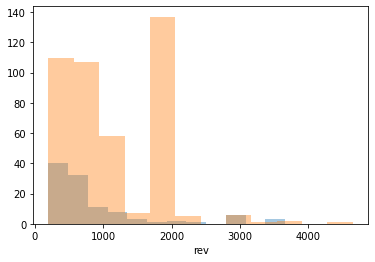

In [56]:
# Посмотрю распределение оплат
sns.distplot(payment.query('grp == "A"').rev, kde=False)
sns.distplot(payment.query('grp == "B"').rev, kde=False)

**на графике видно, что распределения отличаются от нормального, ввиду чего сравнение с помощью теста Стьюдента может быть не корректным (ошибка первого рода)**

**использую бутстрап:**

In [57]:
def get_bootstrap(
    # Оплаты группы A
    data_A,
    # Оплаты группы B
    data_B,
    # Количество выборок
    n_resamples=1000,
    # Статистическая мера (среднее)
    statistic=np.mean,
    # Уровень значимости
    confidence_level=0.95
):
    boot_data = []
    for i in tqdm(range(n_resamples)):    # извлечение подвыборок
        # Выборка группы A
        samples_A = data_A.sample(len(data_A), replace=True).values
        # Выборка группы B
        samples_B = data_B.sample(len(data_A), replace=True).values
        # Добавление в список
        boot_data.append(statistic(samples_A) - statistic(samples_B))
    
    # Запись в датафрейм    
    bootstrap_data = pd.DataFrame(boot_data)
    
    # Левый квантиль
    left_q = (1 - confidence_level) / 2
    # Правый квантиль
    right_q = 1 - (1 - confidence_level) / 2
    quantiles = bootstrap_data.quantile([left_q, right_q])

    pvalue_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    pvalue_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    pvalue = min(pvalue_1, pvalue_2) * 2

    # Гистограмма
    plt.hist(bootstrap_data[0], bins=30, histtype='barstacked', color='orange')
                
    plt.style.use('ggplot')
    plt.vlines(quantiles, ymin=0, ymax=100)
    plt.xlabel('bootstrap_data')
    plt.ylabel('frequency range')
    plt.title('Histogram of bootstrap_data')
    plt.show()

    return {'boot_data': boot_data,
            'quantiles': quantiles,
            'pvalue': pvalue}

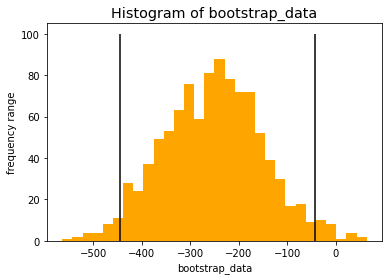

In [58]:
# результат на графике
booted_data = get_bootstrap(payment.query('grp == "A"').rev,
                            payment.query('grp == "B"').rev)

In [60]:
# квантили
booted_data['quantiles']

,0
0.025,-444.867302
0.975,-43.346736


In [59]:
# p-value
booted_data['pvalue']

0.01365695245916501

**p-value < 0.05. Это значит, что есть основание отклонить нулевую гипотезу о равенстве групп**

**т.е. на основании бутстрапа можно утверждать, что статистически значимые различия в сравниваемых группах присутствуют**